In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time_lib
import random

from tqdm import tqdm
import datetime

import multiprocessing

from scripts.dynamics import vecField
from scripts.plotting import plot_results
from scripts.ode_solvers import solver
from scripts.parareal import parallel_solver
from scripts.repeated_experiments import run_experiment

from joblib import Parallel, delayed,parallel_config
from tqdm import tqdm  

In [2]:
number_iterates = 100

system = "Burger1W"
nodes = "uniform"

with parallel_config(backend="loky", inner_max_num_threads=2):
        output = Parallel(n_jobs=2)(delayed(run_experiment)((system,nodes)) for _ in tqdm(range(number_iterates)))
#output = []
#for i in tqdm(range(number_iterates)):
#        output.append(list((run_experiment)((data,weight[i],bias[i]))))

total_time, avg_coarse_step = list(zip(*output))
total_time = np.array(total_time)
avg_coarse_step = np.array(avg_coarse_step)

median_cost = np.median(total_time)
median_coarse_steps = np.median(avg_coarse_step)
print("\n\n")
print(f"The median cost over {number_iterates} of the hybrid parareal is {median_cost}")
print(f"The median cost of one coarse step over {number_iterates} of the hybrid parareal is {median_coarse_steps}")

if system=="BurgerQ":
        name_file = "savedReports/report_Burger_quadratic.txt"
elif system=="Burger1W":
        name_file = "savedReports/report_Burger_one_wave.txt"
elif system=="BurgerSW":
        name_file = "savedReports/report_Burger_sum_waves.txt"
else:
        name_file = f"savedReports/report_{system}.txt"
        
with open(name_file, "w") as file1:
    # Writing data to a file
    file1.write('=========================================================================\n')
    file1.write('New experiment run at: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
    file1.write('\n=========================================================================\n')
    file1.write(f"The median cost over {number_iterates} of the hybrid parareal is {median_cost}\n")
    file1.write(f"The median cost of one coarse step over {number_iterates} of the hybrid parareal is {median_coarse_steps}\n")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [35:32<00:00, 21.32s/it]





The median cost over 100 of the hybrid parareal is 41.61002540588379
The median cost of one coarse step over 100 of the hybrid parareal is 0.347419810295105


In [10]:
_,_,coarse_approx,networks,data = run_experiment([system,nodes],return_nets=True,verbose=False)

system = data["system"]
LB = data["LB"]
UB = data["UB"]
L = data["L"]
y0 = data["y0"]
n_x = data["n_x"]
n_t = data["n_t"]
system = data["system"]
nodes = data["nodes"]
act_name = data["act_name"]
t_max = data["t_max"]
vecRef = data["vecRef"]
num_t = data["num_t"]
number_processors = data["number_processors"]
time = data["time"]

In [11]:
def get_detailed_solution():
    num_steps = int((networks[0].dt / vecRef.dt_fine))
    print(num_steps)
    time_plot = np.linspace(0,networks[0].dt,num_steps+1)
    sol = networks[0].plotOverTimeRange(time_plot)
    total_time = time_plot
    for i in np.arange(1,len(networks)):
        num_steps = int((networks[i].dt / vecRef.dt_fine))
        time_plot = np.linspace(0,networks[i].dt,num_steps+1)[1:]
        sol = np.concatenate((sol,networks[i].plotOverTimeRange(time_plot)),axis=1)
        total_time = np.concatenate((total_time,time_plot+total_time[-1]),axis=0)
    return sol,total_time

In [12]:
network_sol, time_plot = get_detailed_solution()

2


In [13]:
num_fine_steps_per_coarse = ( t_max / (num_t-1) ) / vecRef.dt_fine
num_fine_steps = t_max / vecRef.dt_fine

In [14]:
initial = time_lib.time()
arg = [[y0,time_plot[-1],time_plot],vecRef]
output,time_plot_sequential = solver(arg,final=False)
final = time_lib.time()
print(f"Computational time sequential: {final-initial}")
print(f"Computational time parallel with {number_processors} processors: {median_cost}")
print(f"Average cost fine steps to cover one coarse step: {(final - initial) / num_fine_steps * num_fine_steps_per_coarse}")

with open(name_file, "a") as file1:
    # Writing data to a file
    file1.write(f"Computational time sequential: {final-initial}\n")
    file1.write(f"Computational time parallel with {number_processors} processors: {median_cost}\n")
    file1.write(f"Average cost fine steps to cover one coarse step: {(final - initial) / num_fine_steps * num_fine_steps_per_coarse}\n")

Computational time sequential: 1.0479826927185059
Computational time parallel with 5 processors: 41.61002540588379
Average cost fine steps to cover one coarse step: 0.020959653854370118


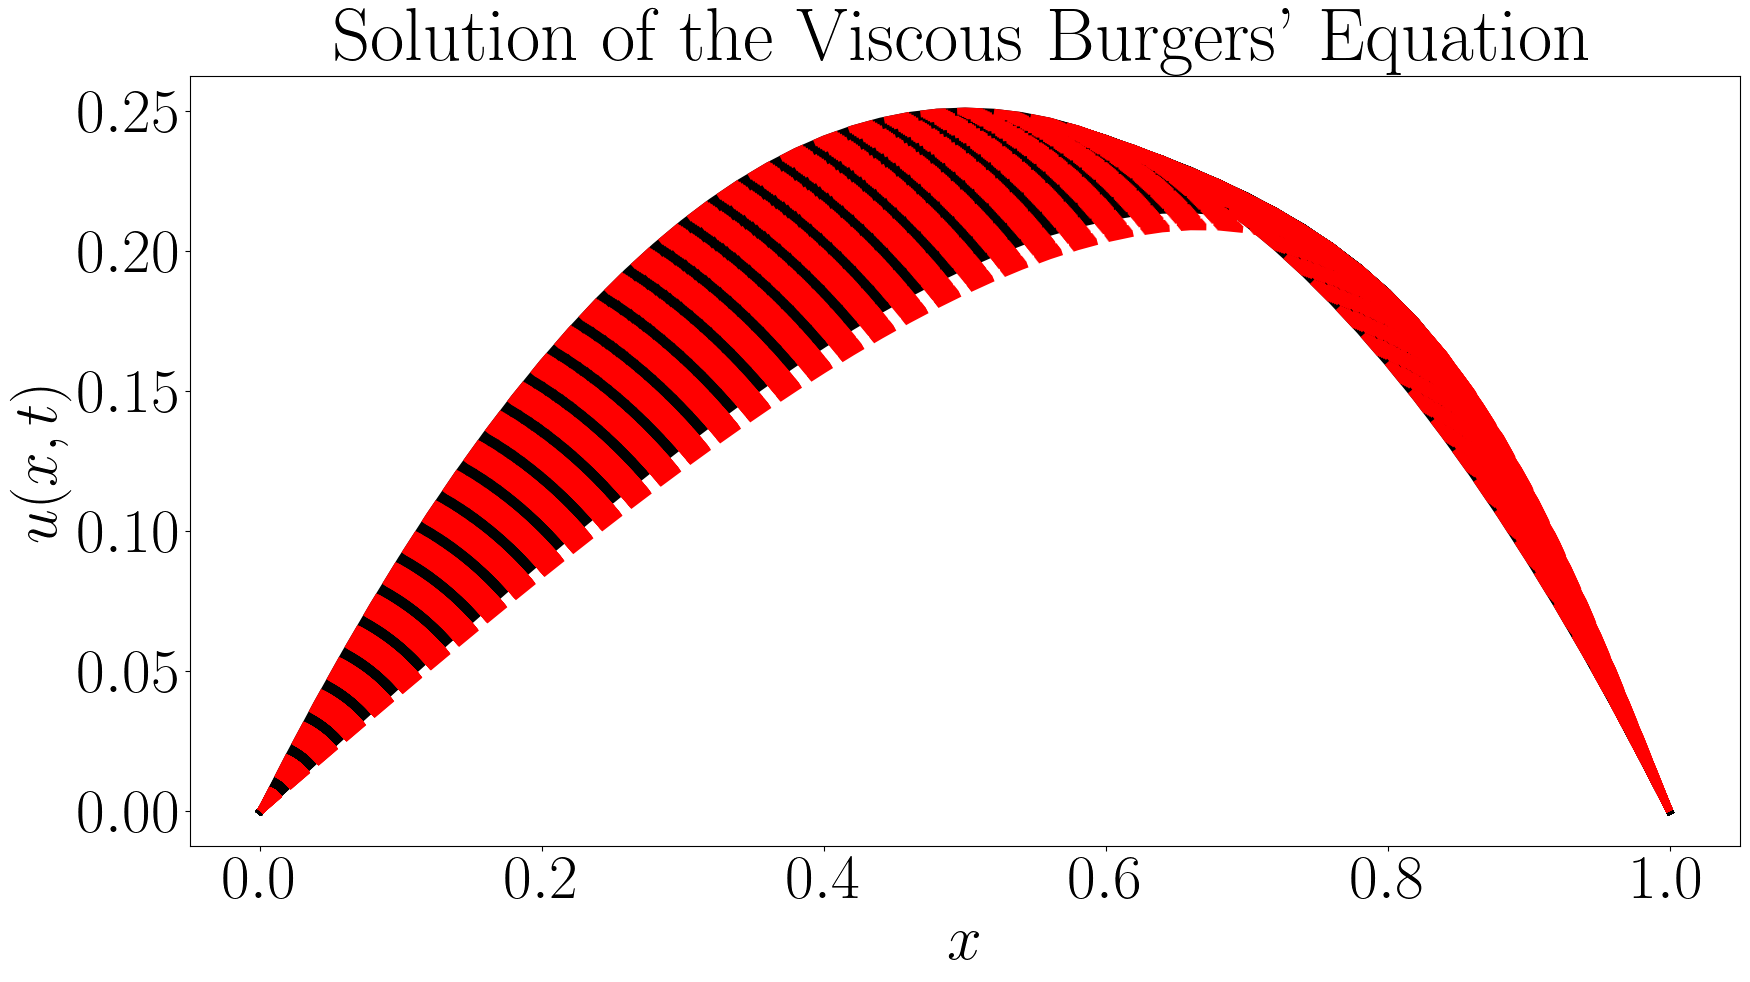

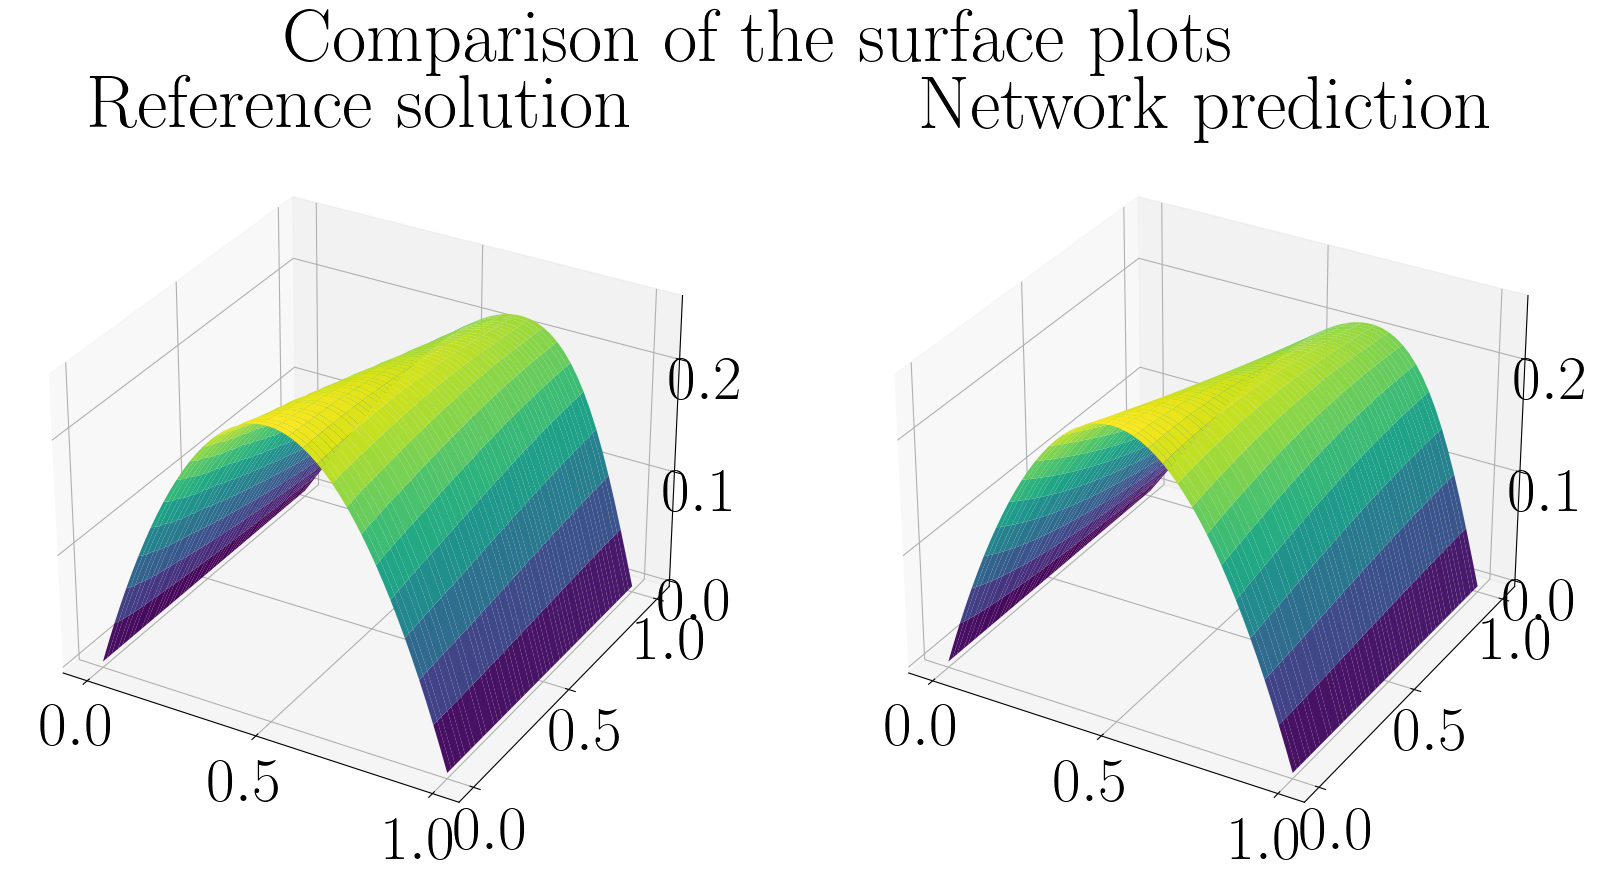

In [15]:
if len(y0)==2:
    list_of_labels = [r"$\mathbf{x}_1$",r"$\mathbf{x}_2$"]
elif len(y0)==3:
    list_of_labels = [r"$\mathbf{x}_1$",r"$\mathbf{x}_2$",r"$\mathbf{x}_3$"]
elif len(y0)==4:
    list_of_labels = [r"$\mathbf{x}_1$",r"$\\mathbf{x}_1'$",r"$\mathbf{x}_2$",r"$\mathbf{x}_2'$"]
else:
    list_of_labels = []
plot_results(y0,coarse_approx,networks,system,time_plot,time_plot_sequential,output,network_sol,list_of_labels,median_cost,time,n_x,n_t,L,vecRef,number_iterates=number_iterates)

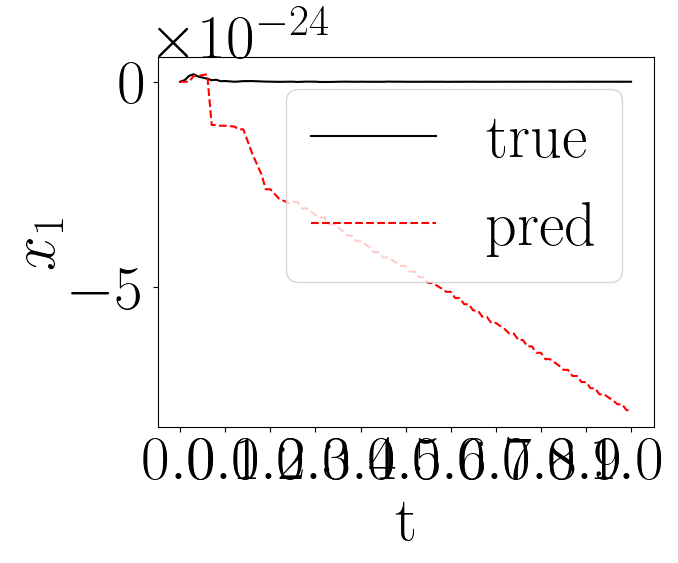

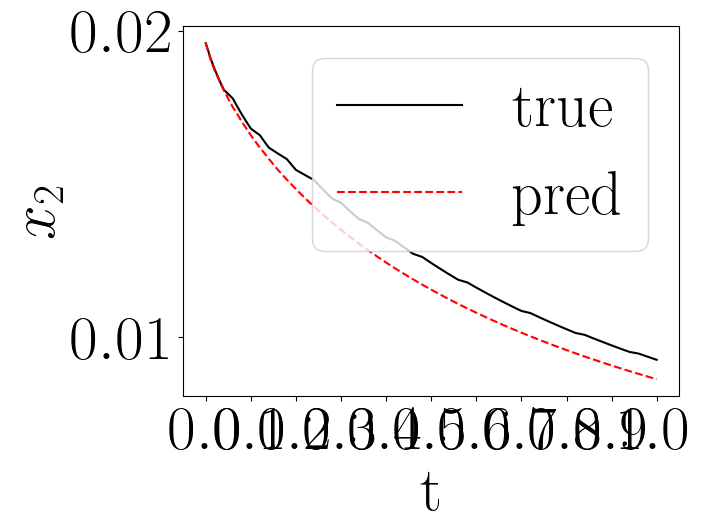

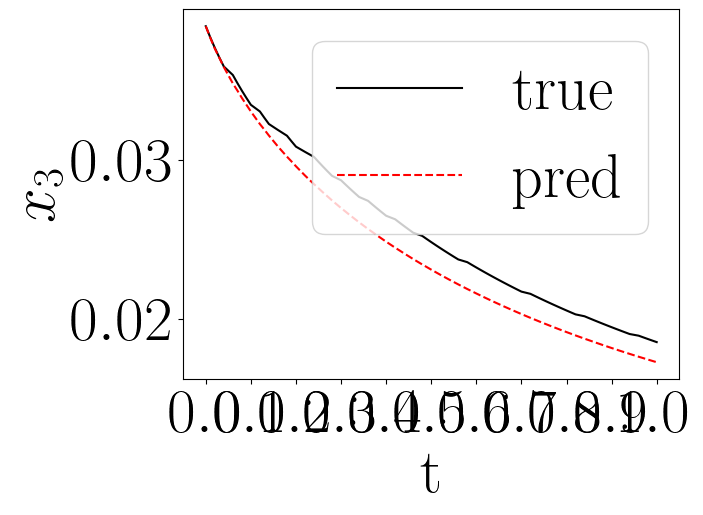

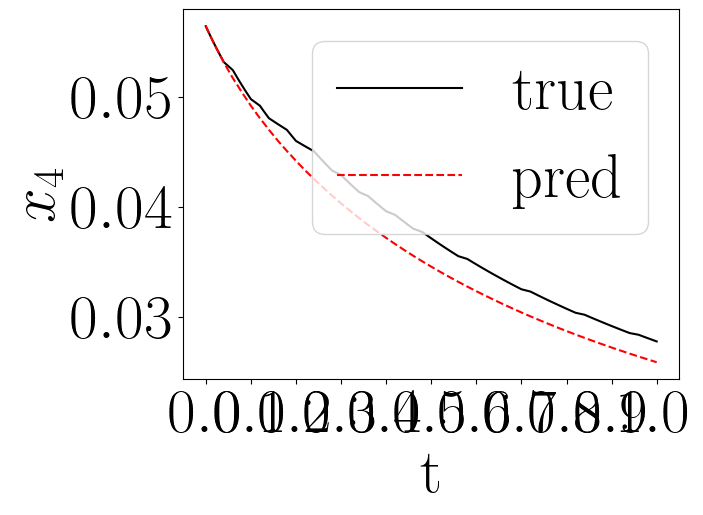

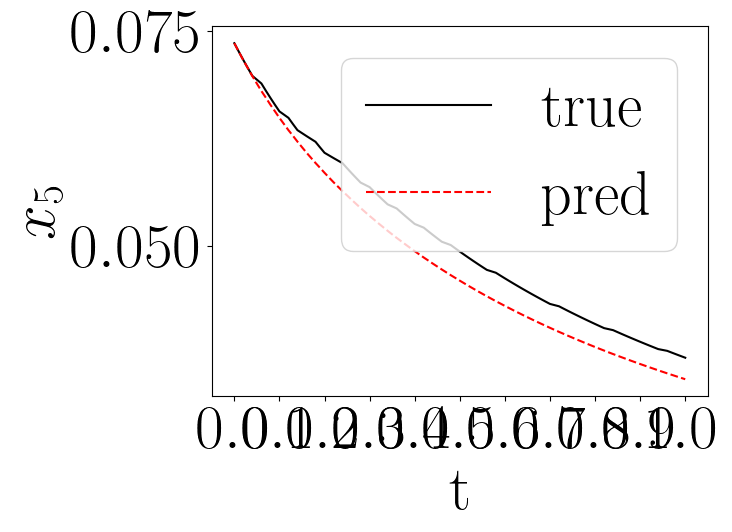

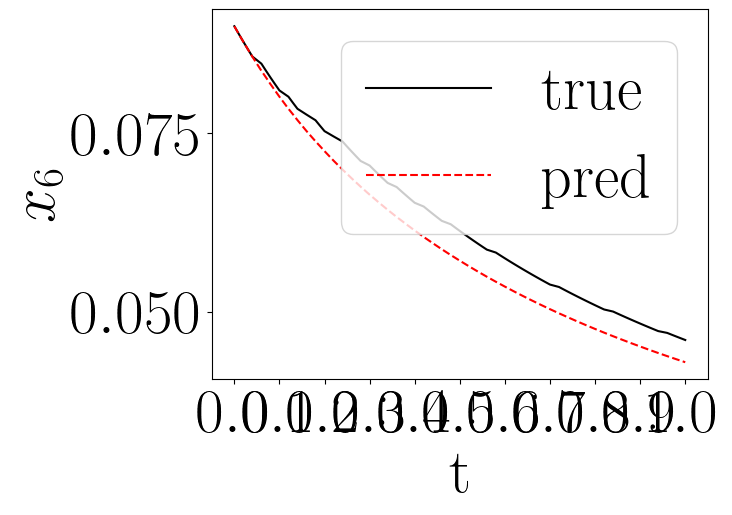

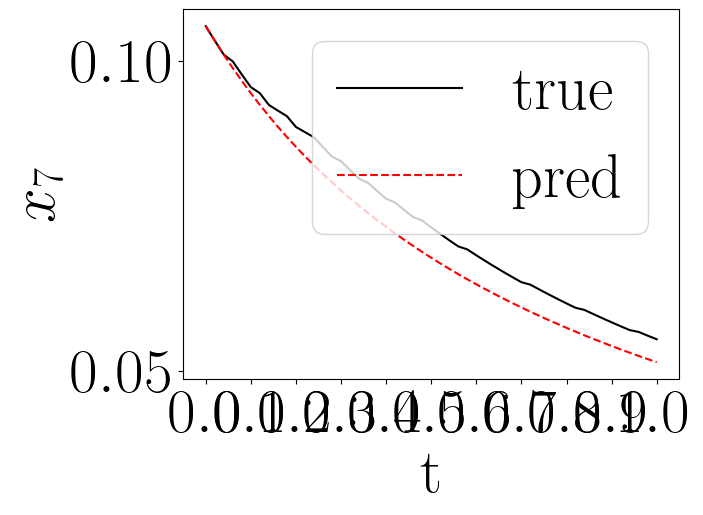

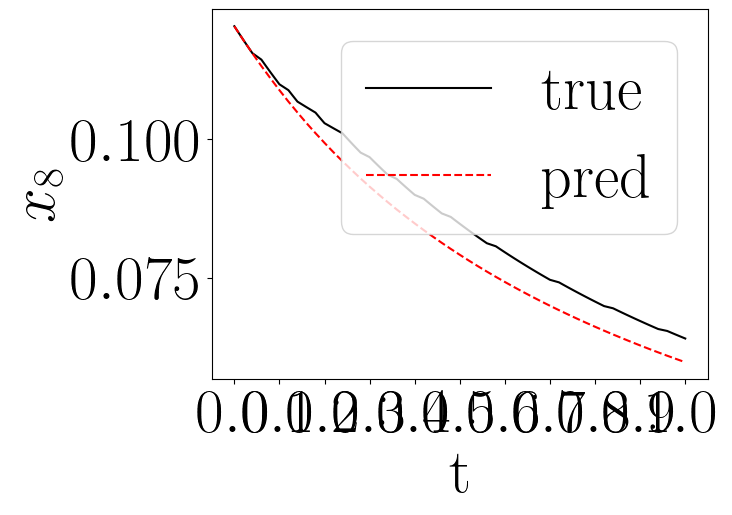

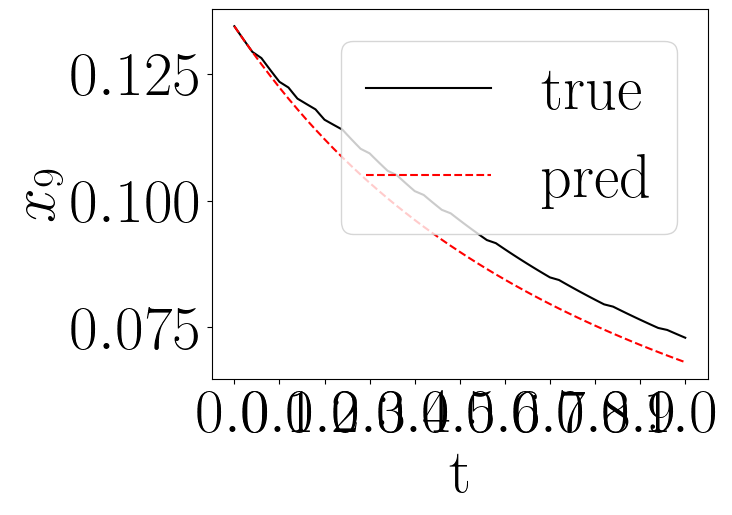

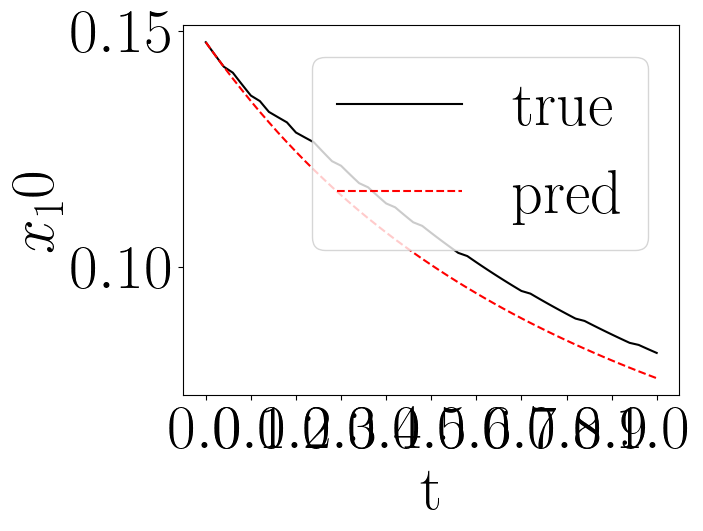

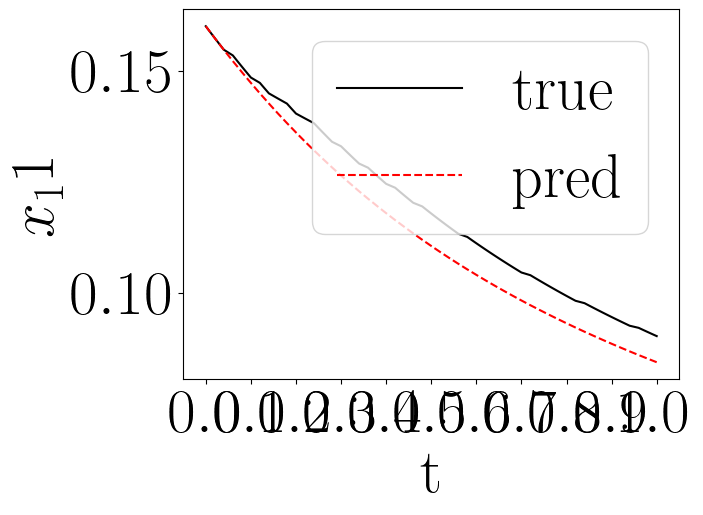

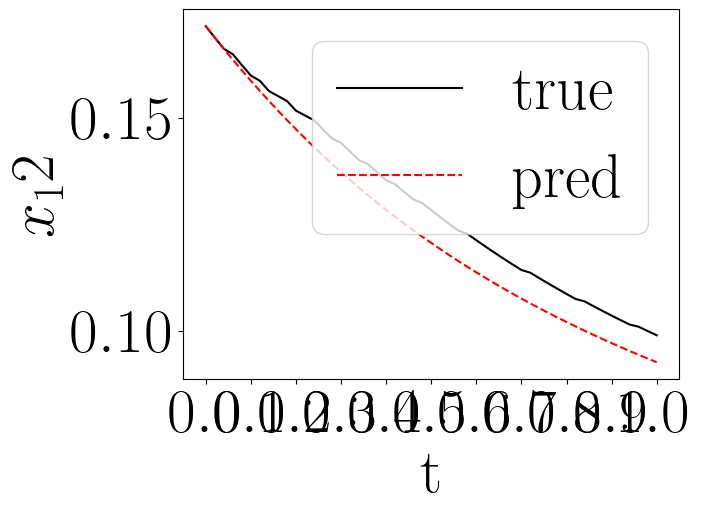

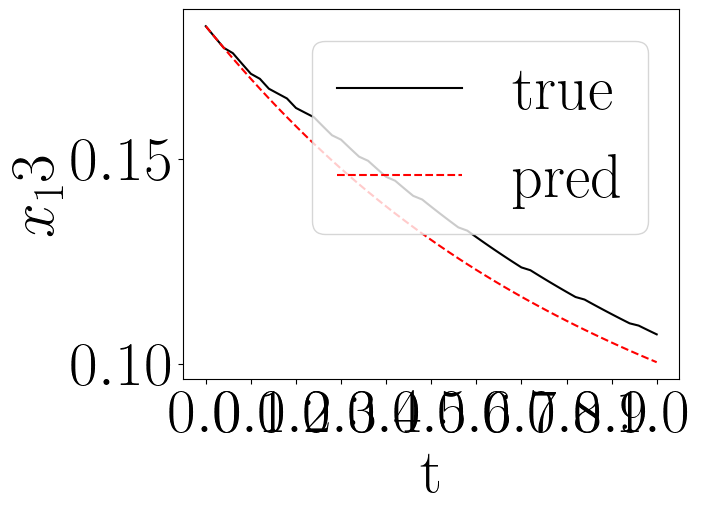

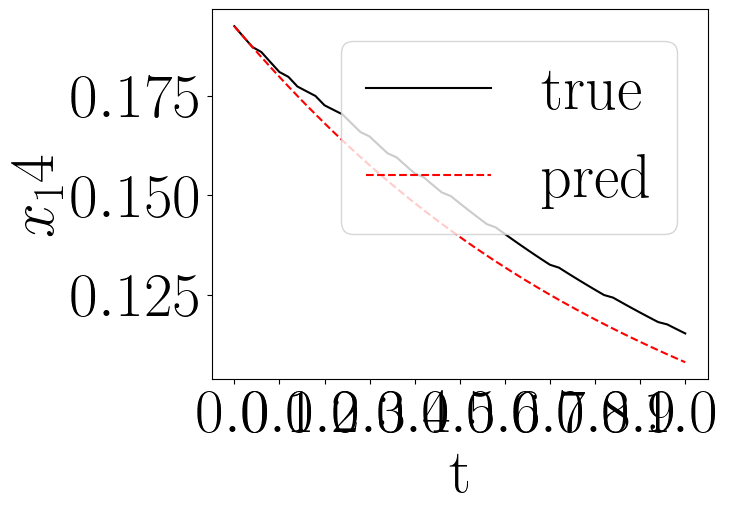

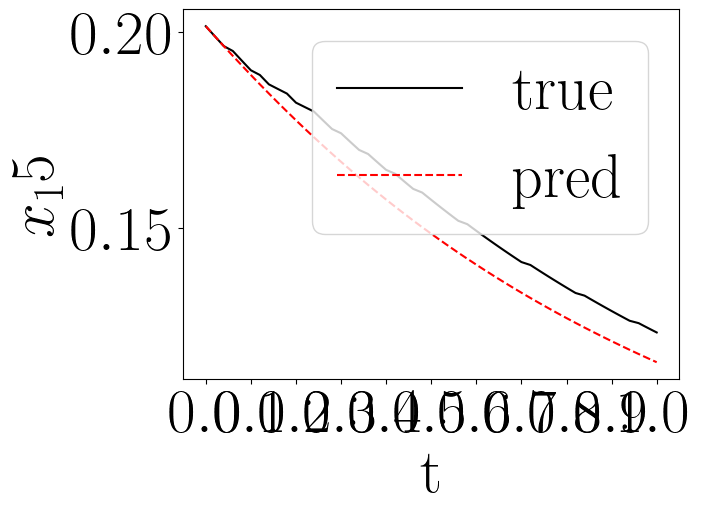

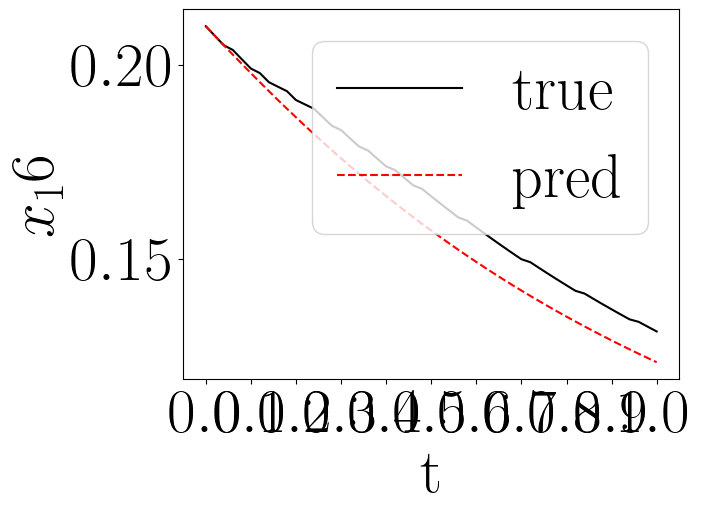

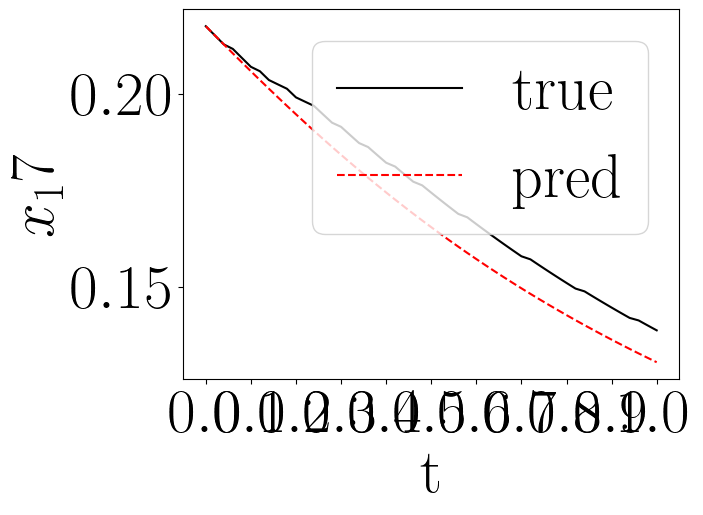

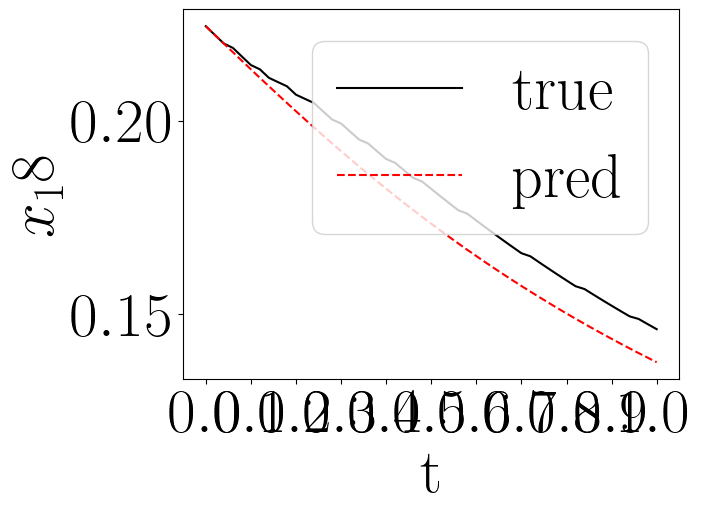

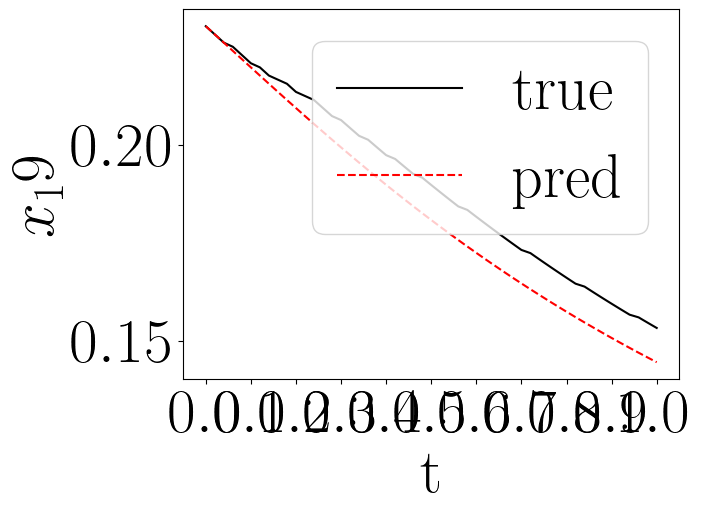

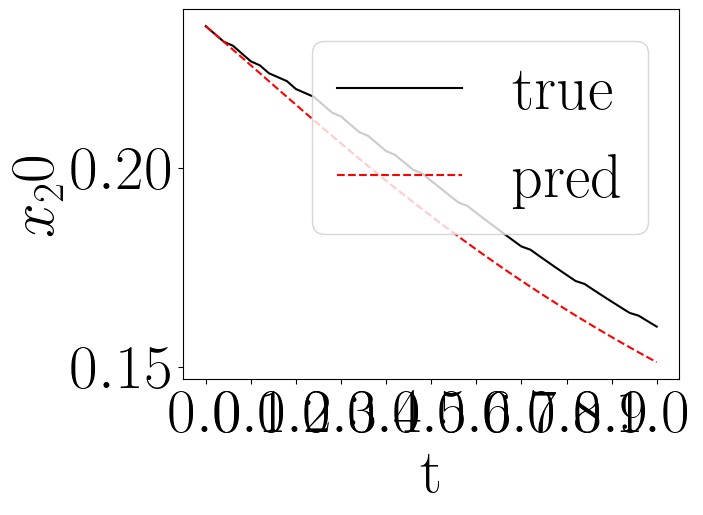

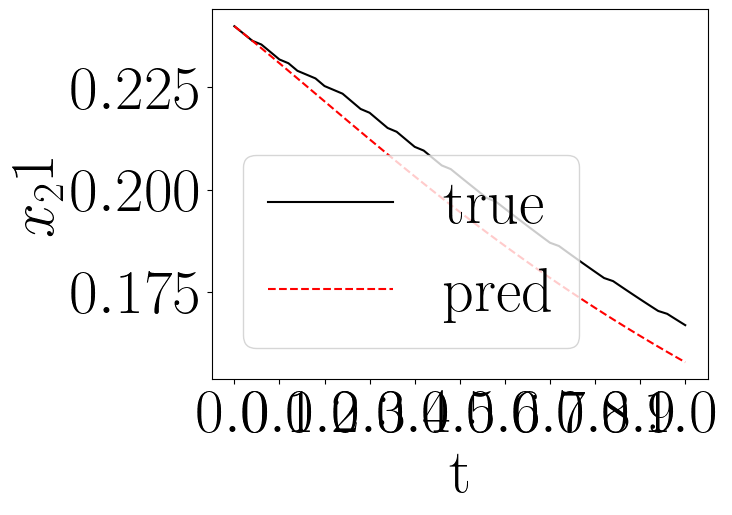

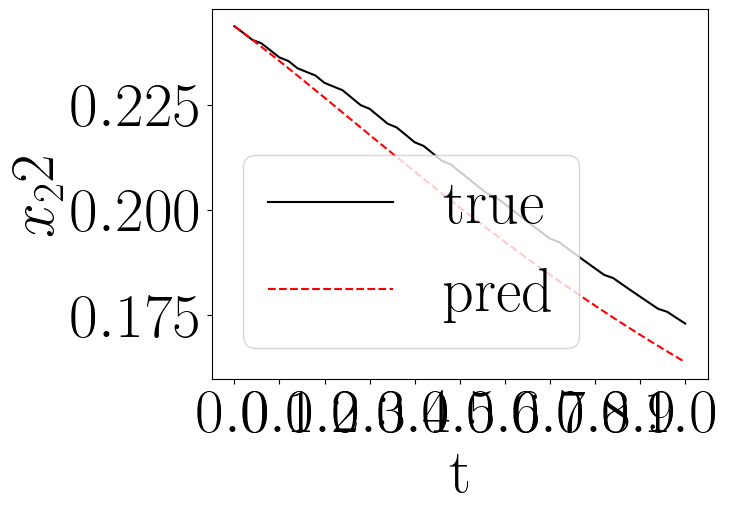

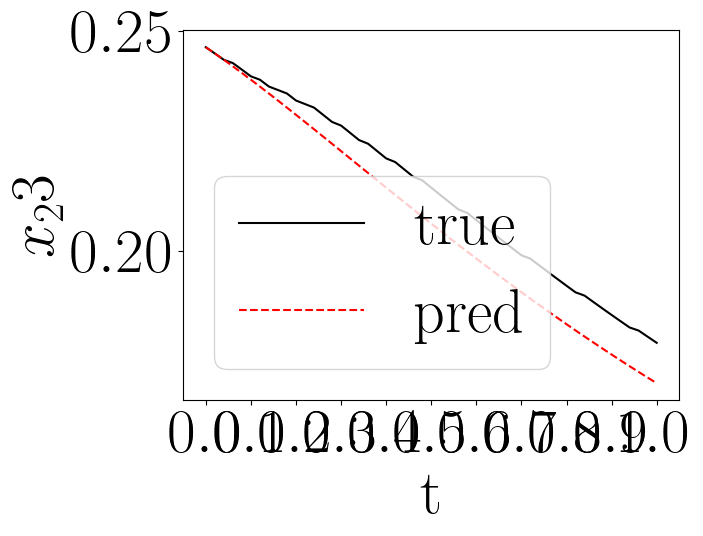

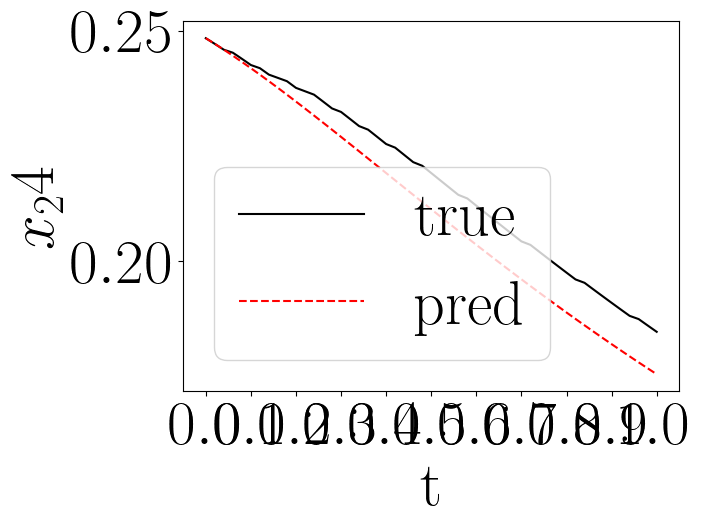

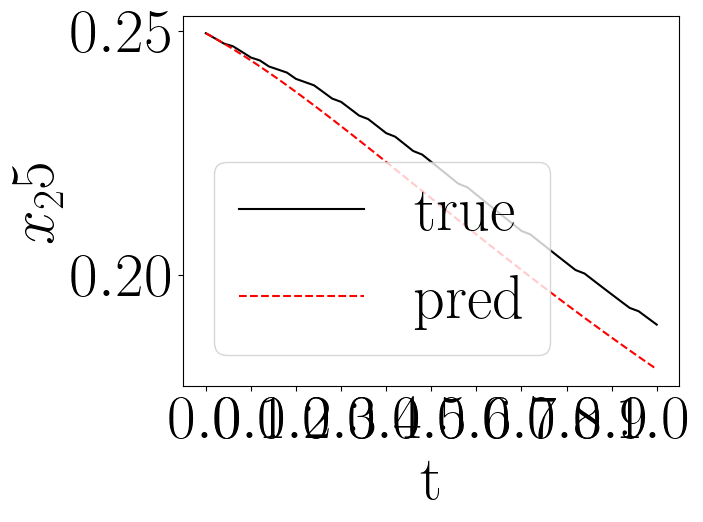

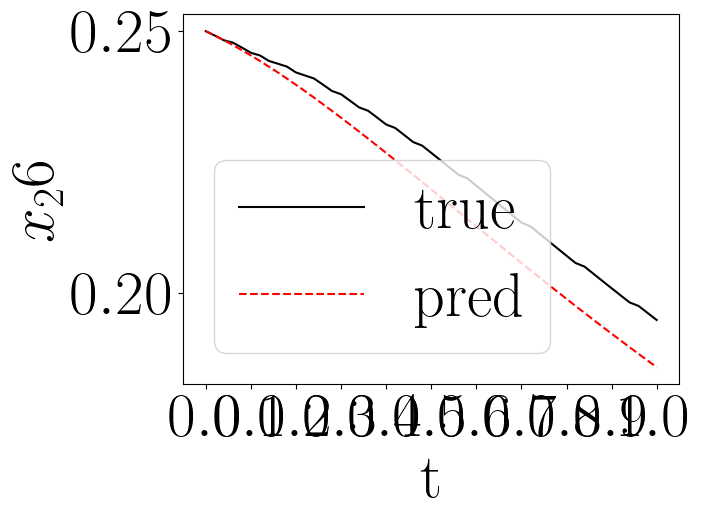

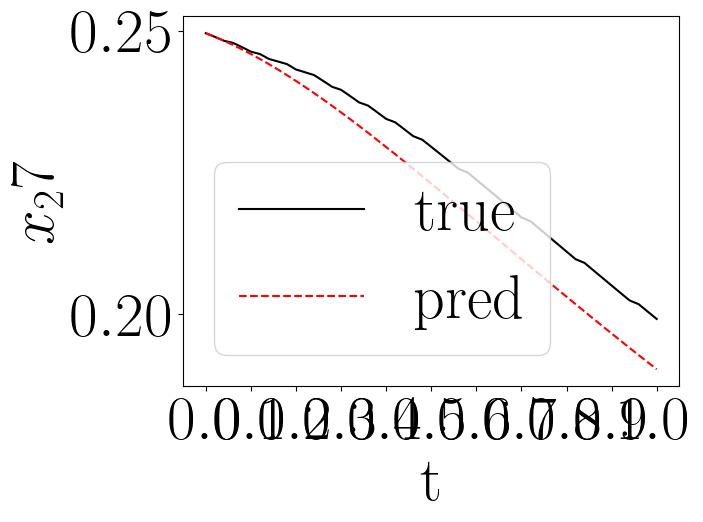

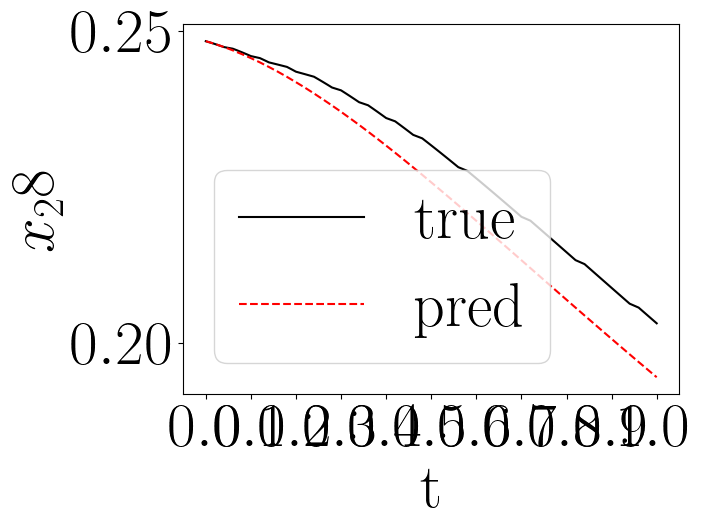

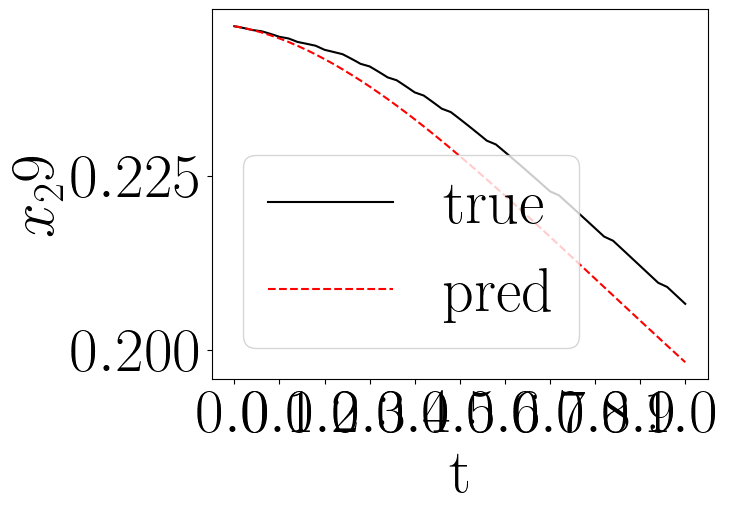

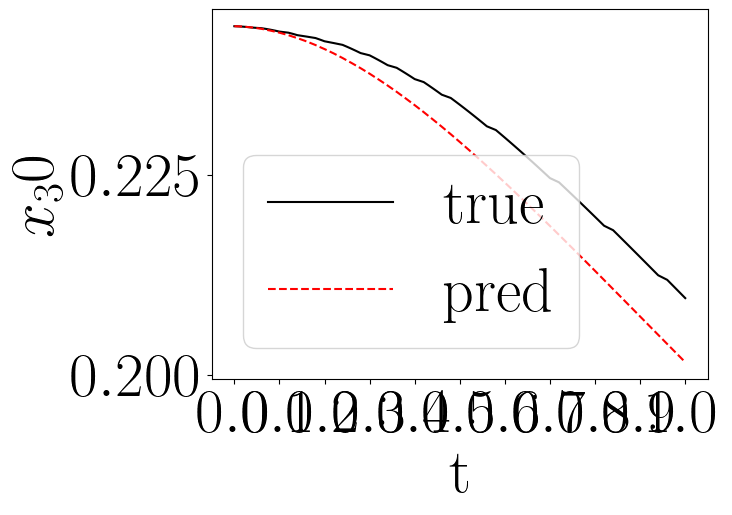

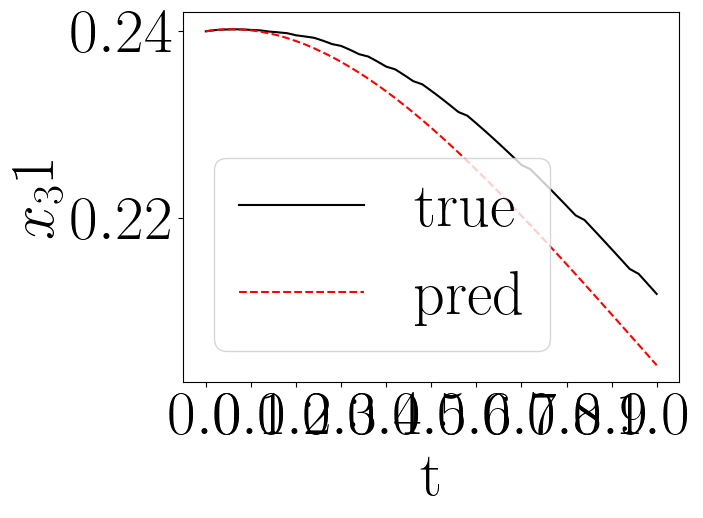

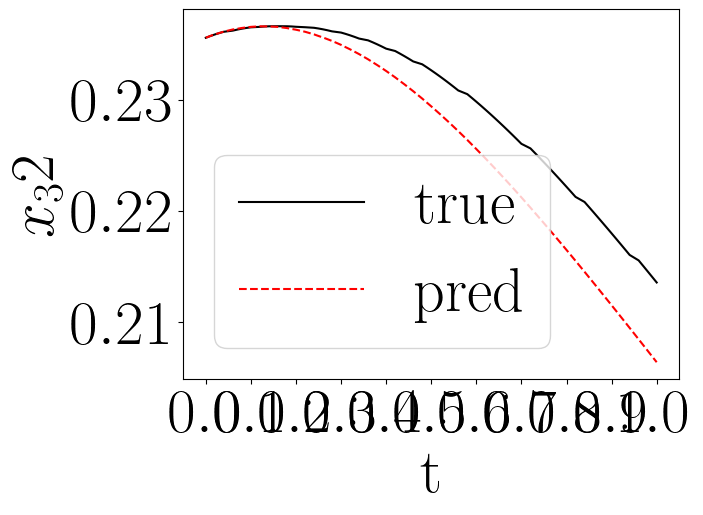

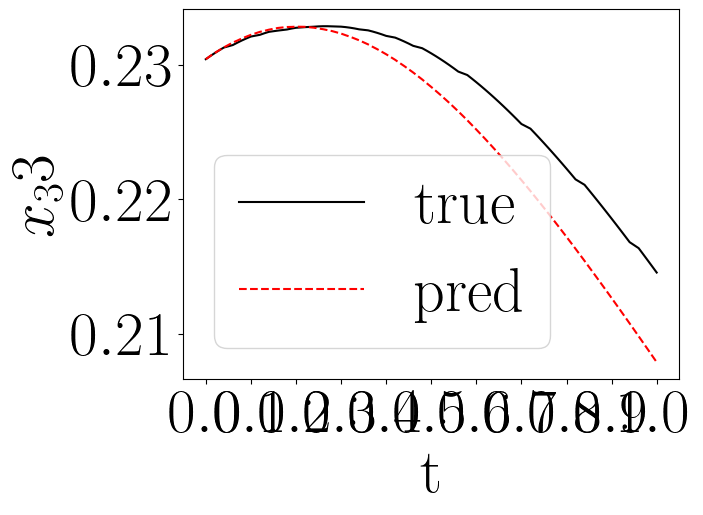

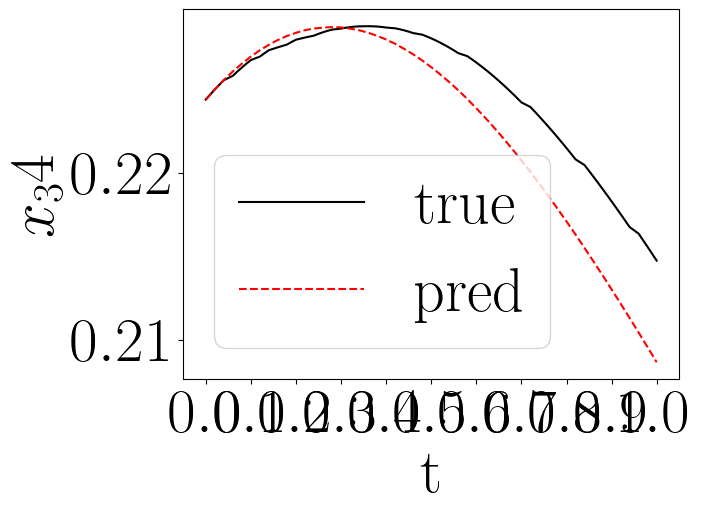

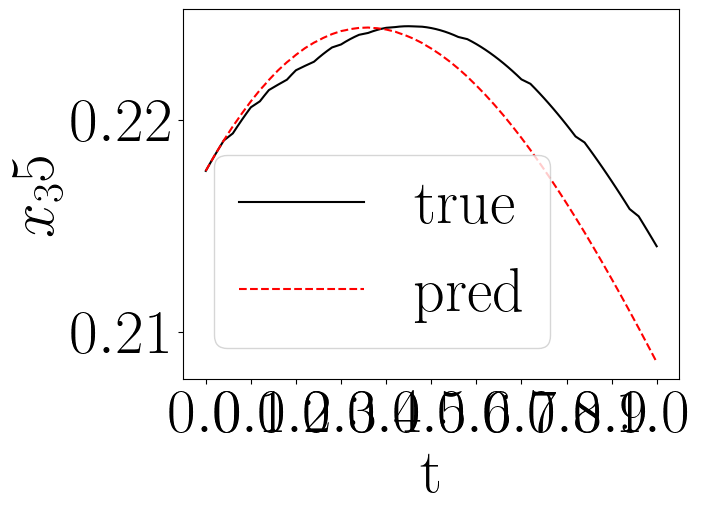

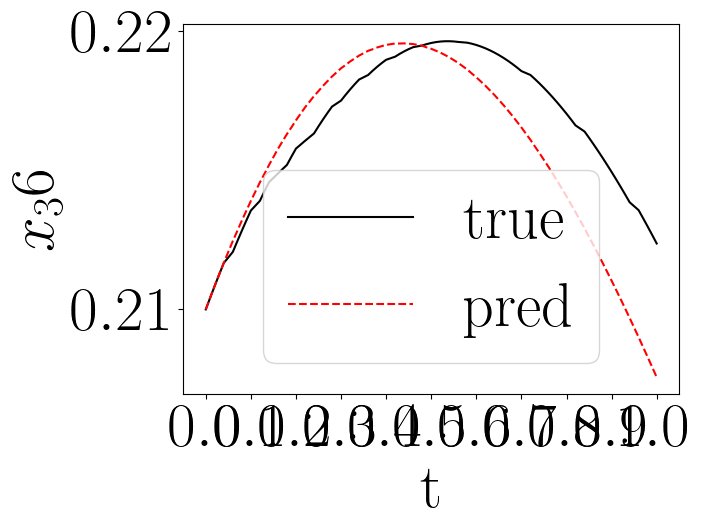

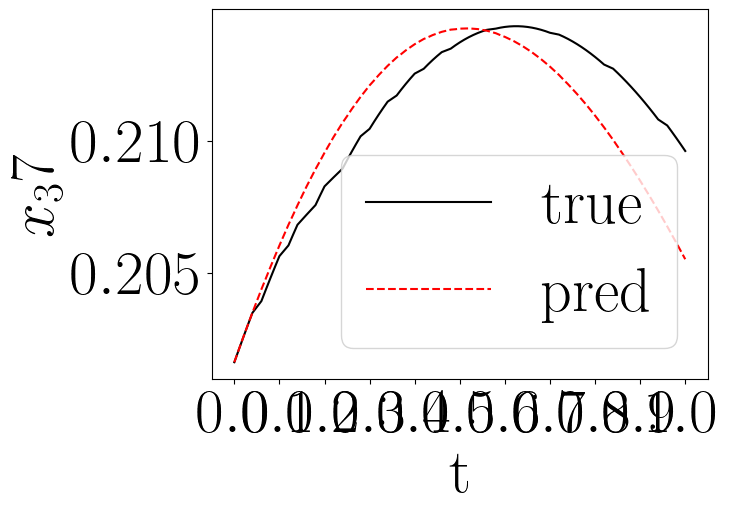

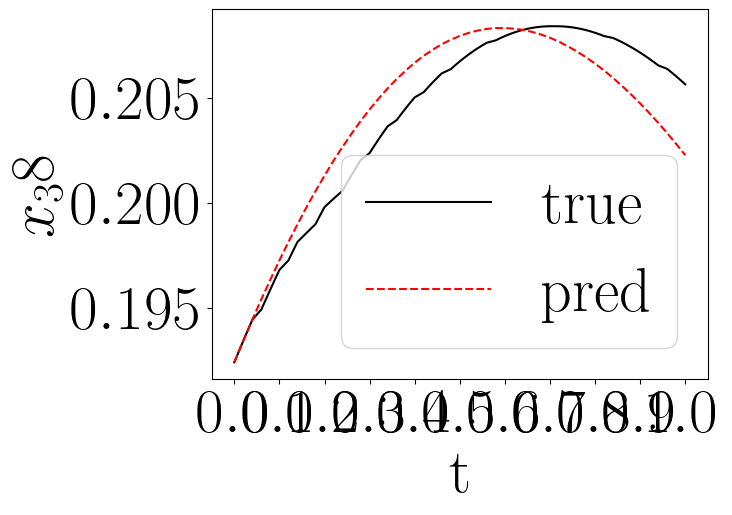

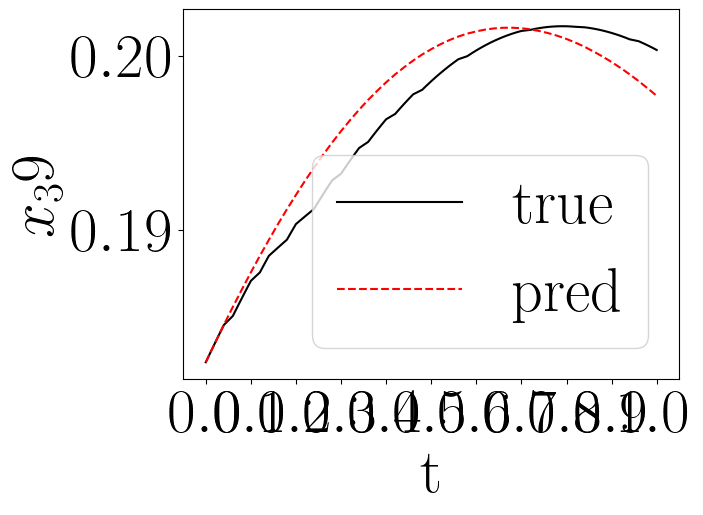

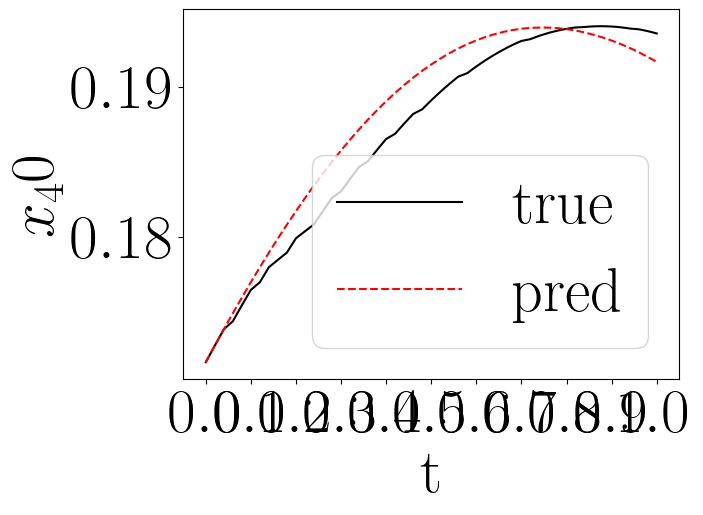

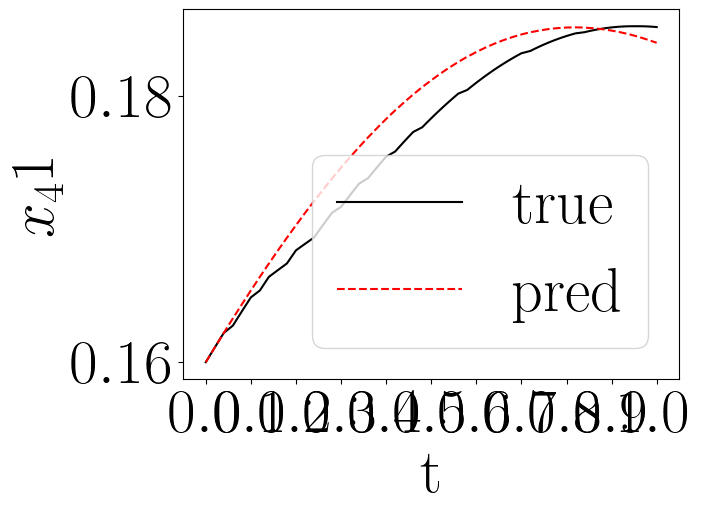

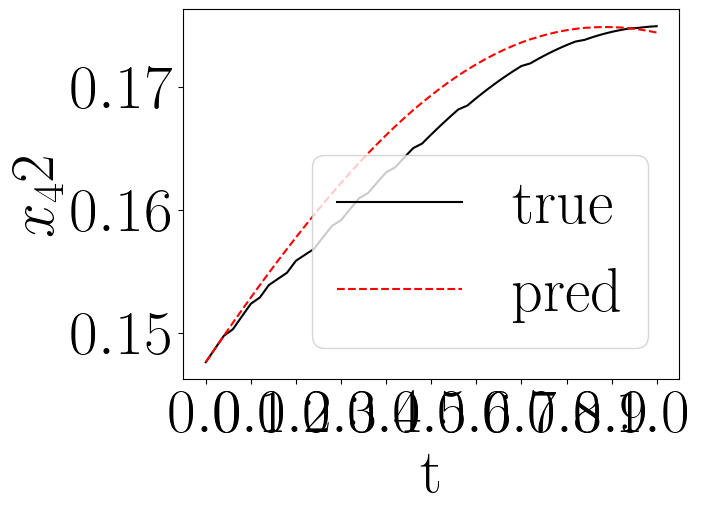

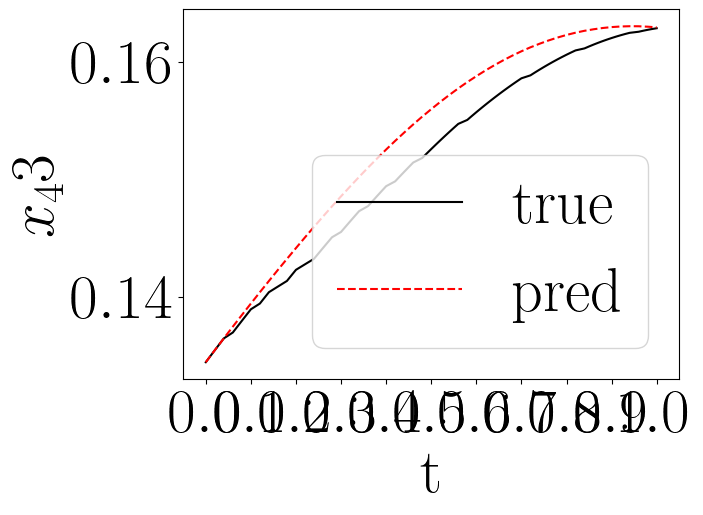

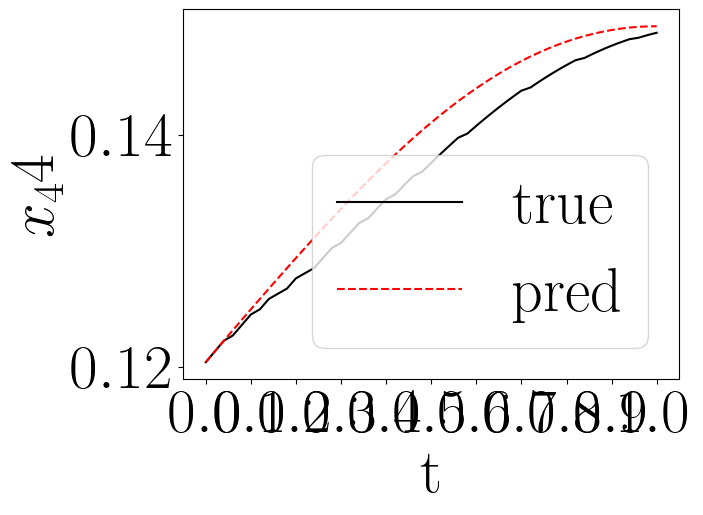

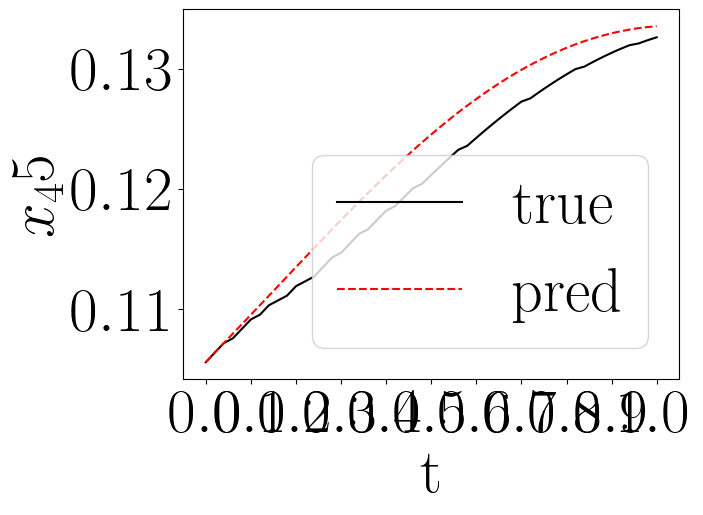

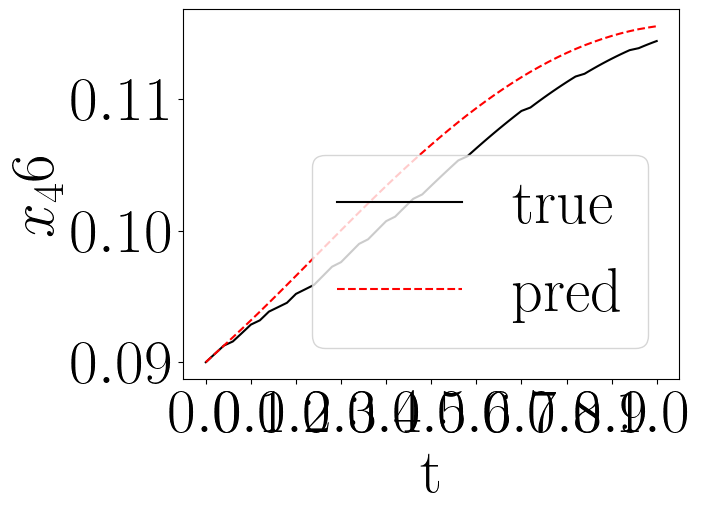

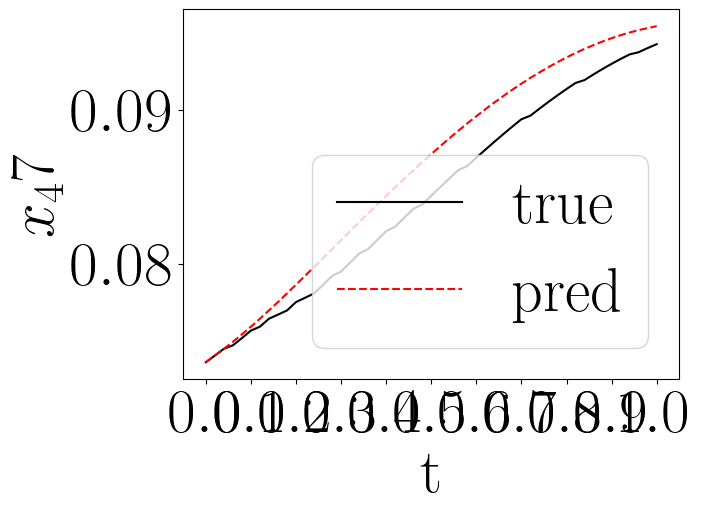

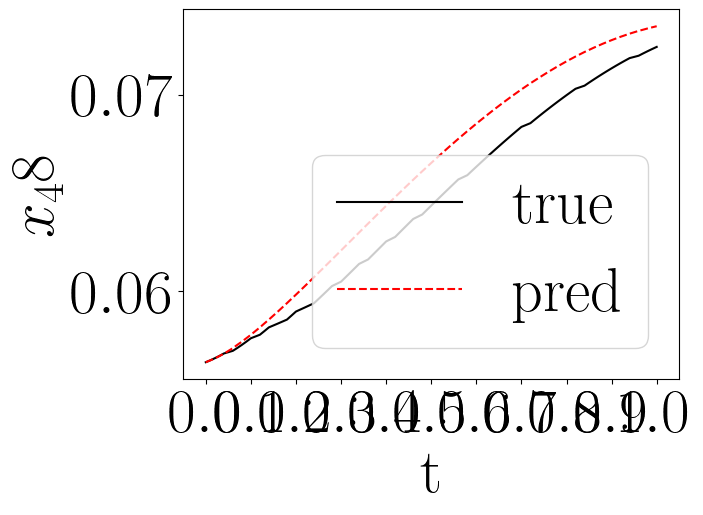

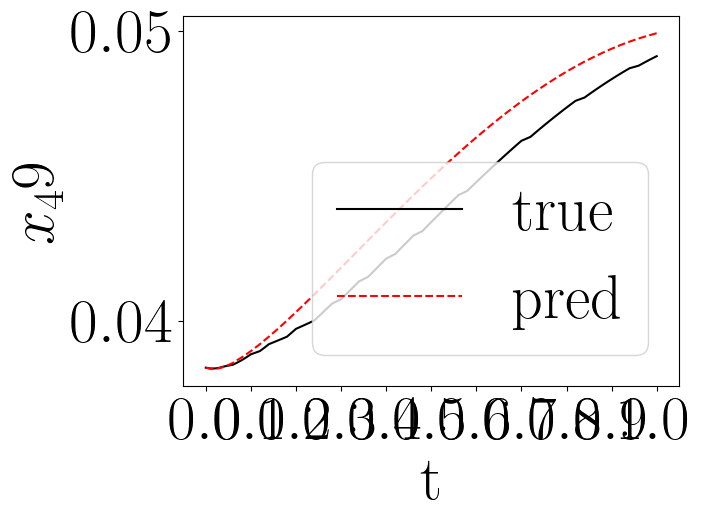

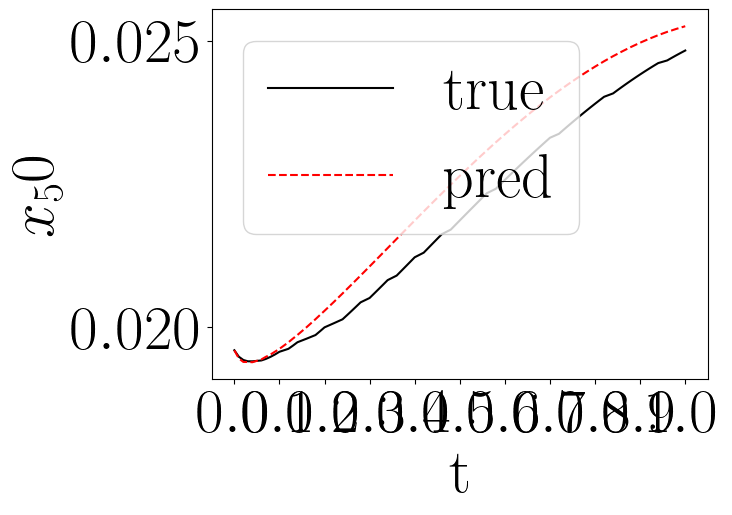

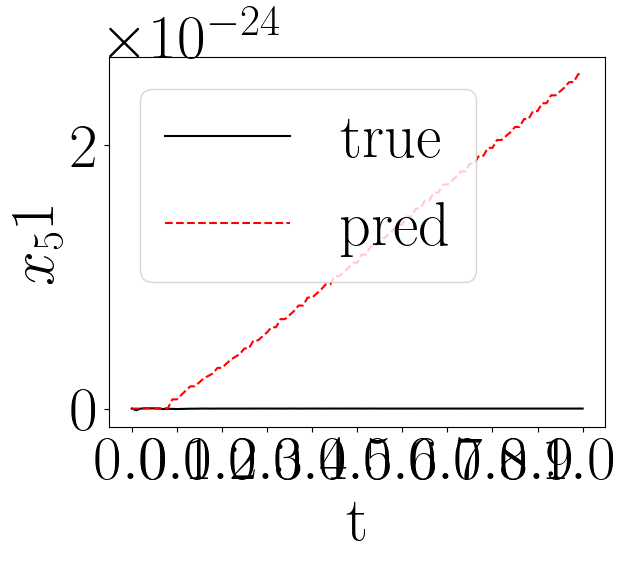

In [16]:
if system=="Burger":
    vec = vecRef

    for i in range(vec.N):
        fig = plt.figure()
        plt.plot(time_plot, output[:,i],'k-',label='true')
        plt.plot(time_plot, network_sol[i],'r--',label='pred')
        plt.xlabel("t")
        plt.ylabel(fr"$x_{i+1}$")
        plt.xticks(np.linspace(0,1,11))
        plt.legend()
        plt.show();